In [1]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sms
import seaborn as sns
from scipy.stats import chisquare
from shapely.geometry import Point

In [2]:
#specify relevant columns for fires dataset
columns=['CalYear', 'PropertyCategory', 'IncGeo_BoroughCode', 'IncidentGroup', 'Easting_rounded', 'Northing_rounded']

In [3]:
#load csv files while filtering only 2021 incidents 

chunksize = 10000  # tamaño del fragmento
fires = []

for chunk in pd.read_csv("fires.csv", usecols=columns, chunksize=chunksize):
    # Filtrar filas con CalYear == 2021
    fires.append(chunk[chunk["CalYear"] == 2021])

#Concatenate all chunks
fires= pd.concat(fires)

In [4]:
#filter only incidents on dwellings
fires = fires[(fires.PropertyCategory == "Dwelling") & (fires.IncidentGroup == "Fire")]

In [5]:
fires = fires.drop(["PropertyCategory", "IncidentGroup"], axis=1)


In [6]:
len(fires)

4914

In [7]:
fires.head(10)

,CalYear,IncGeo_BoroughCode,Easting_rounded,Northing_rounded
309557,2021,E09000009,520050,179850
309558,2021,E09000022,530350,176350
309607,2021,E09000032,527950,173950
309609,2021,E09000033,526350,182550
309615,2021,E09000033,525750,181450
309626,2021,E09000027,512450,173250
309667,2021,E09000015,513850,186850
309671,2021,E09000004,547850,179150
309678,2021,E09000032,528250,176050
309680,2021,E09000008,531850,160950


,NAME,GSS_CODE,geometry
0,Kingston upon Thames,E09000021,"POLYGON ((516401.6 160201.8, 516407.3 160210.5..."
1,Croydon,E09000008,"POLYGON ((535009.2 159504.7, 535005.5 159502, ..."
2,Bromley,E09000006,"POLYGON ((540373.6 157530.4, 540361.2 157551.9..."
3,Hounslow,E09000018,"POLYGON ((521975.8 178100, 521967.7 178096.8, ..."
4,Ealing,E09000009,"POLYGON ((510253.5 182881.6, 510249.9 182886, ..."


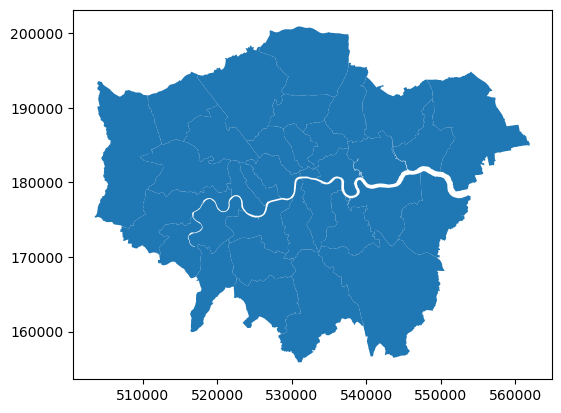

In [8]:
columns=['NAME', 'GSS_CODE', 'geometry']

#Load UK's borough boundaries
boros = gpd.read_file("London_Borough_Excluding_MHW.shp")[columns]

boros.plot()
boros.head()

In [9]:
geometry = [Point(xy) for xy in zip(fires["Easting_rounded"], fires["Northing_rounded"])]
fires_gdf = gpd.GeoDataFrame(fires, geometry=geometry)


In [10]:
fires_gdf.set_crs(boros.crs, inplace=True)

,CalYear,IncGeo_BoroughCode,Easting_rounded,Northing_rounded,geometry
309557,2021,E09000009,520050,179850,POINT (520050 179850)
309558,2021,E09000022,530350,176350,POINT (530350 176350)
309607,2021,E09000032,527950,173950,POINT (527950 173950)
309609,2021,E09000033,526350,182550,POINT (526350 182550)
309615,2021,E09000033,525750,181450,POINT (525750 181450)
...,...,...,...,...,...
419007,2021,E09000030,537650,180750,POINT (537650 180750)
419016,2021,E09000011,538350,177650,POINT (538350 177650)
419027,2021,E09000032,527450,174550,POINT (527450 174550)
419060,2021,E09000003,521650,190650,POINT (521650 190650)


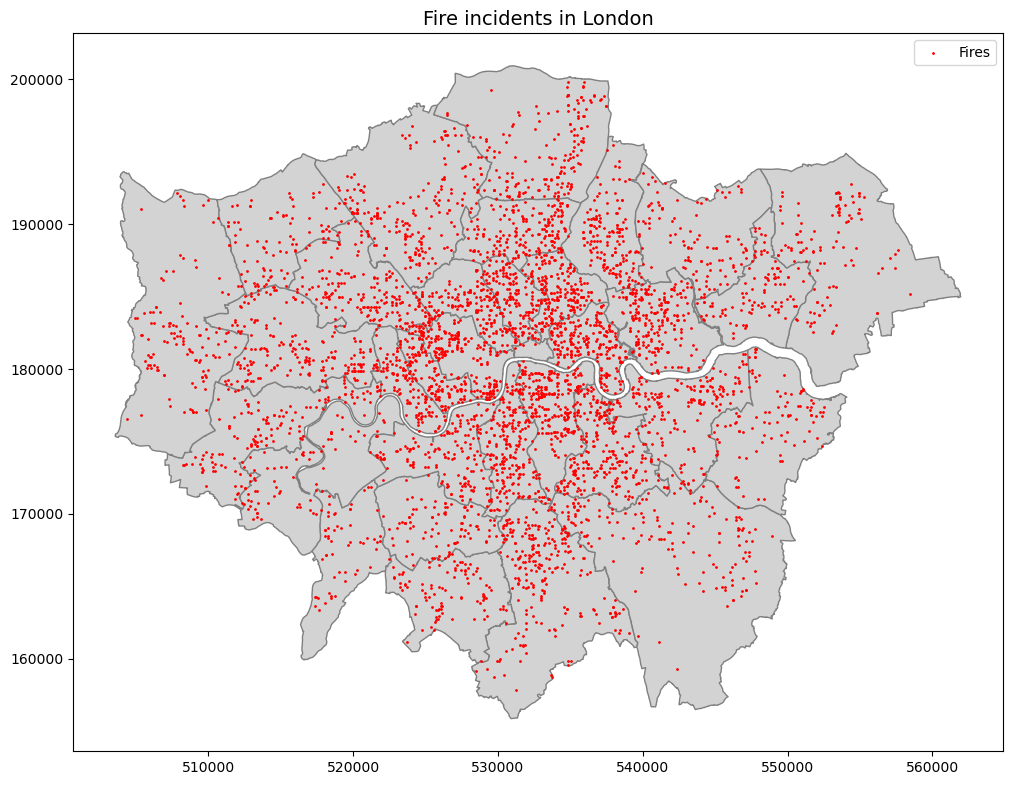

In [11]:
#Set figure
fig, ax = plt.subplots(figsize=(12, 12))

#Plot london boroughs' shapefile
boros.plot(ax=ax, color="lightgrey", edgecolor="grey")

#Plot fire incidents
fires_gdf.plot(ax=ax, color="red", markersize=1, label="Fires")

#Ass info to the graphic
plt.title("Fire incidents in London", fontsize=14)
plt.legend()
plt.show()

Because easting and northing are rounded, it doesn't have enough precision to indicate to which ward it belongs, so fire incidents will be classified by the borough code specified on the csv.

In [12]:
#Count how many fire incidente there are by borough
fire_counts = fires_gdf.groupby('IncGeo_BoroughCode').size().reset_index(name='fire_count')
boros = boros.merge(fire_counts, left_on='GSS_CODE', right_on='IncGeo_BoroughCode', how='left')
boros=boros.drop('IncGeo_BoroughCode', axis=1)

#Fill NAs with zeros
boros['fire_count'] = boros['fire_count'].fillna(0).astype(int)


In [13]:
boros.head()

print(boros['fire_count'].describe())

count     33.000000
mean     148.909091
std       56.595254
min        4.000000
25%      107.000000
50%      159.000000
75%      195.000000
max      240.000000
Name: fire_count, dtype: float64


In [14]:
columns=['Lower tier local authorities Code', 'Observation']
households=pd.read_csv("TS041-2021-2-filtered-2025-01-19T17_52_49Z.csv", usecols=columns)

boros = boros.merge(households, left_on='GSS_CODE', right_on='Lower tier local authorities Code', how='left')
boros.head(15)

,NAME,GSS_CODE,geometry,fire_count,Lower tier local authorities Code,Observation
0,Kingston upon Thames,E09000021,"POLYGON ((516401.6 160201.8, 516407.3 160210.5...",57,E09000021,65626
1,Croydon,E09000008,"POLYGON ((535009.2 159504.7, 535005.5 159502, ...",231,E09000008,152946
2,Bromley,E09000006,"POLYGON ((540373.6 157530.4, 540361.2 157551.9...",161,E09000006,135827
3,Hounslow,E09000018,"POLYGON ((521975.8 178100, 521967.7 178096.8, ...",141,E09000018,102961
4,Ealing,E09000009,"POLYGON ((510253.5 182881.6, 510249.9 182886, ...",185,E09000009,133659
5,Havering,E09000016,"POLYGON ((549893.9 181459.8, 549894.6 181465.7...",108,E09000016,101277
6,Hillingdon,E09000017,"POLYGON ((510599.8 191689.5, 510615.2 191591.3...",120,E09000017,109228
7,Harrow,E09000015,"POLYGON ((510599.8 191689.5, 510660 191690.9, ...",86,E09000015,89642
8,Brent,E09000005,"POLYGON ((525201 182512.6, 525181.5 182521.1, ...",185,E09000005,118612
9,Barnet,E09000003,"POLYGON ((524579.9 198355.2, 524594.3 198321.4...",195,E09000003,148917


In [15]:
boros=boros.drop('Lower tier local authorities Code', axis=1)
boros=boros.rename(columns={'Observation':'households'})

boros.head(33)

,NAME,GSS_CODE,geometry,fire_count,households
0,Kingston upon Thames,E09000021,"POLYGON ((516401.6 160201.8, 516407.3 160210.5...",57,65626
1,Croydon,E09000008,"POLYGON ((535009.2 159504.7, 535005.5 159502, ...",231,152946
2,Bromley,E09000006,"POLYGON ((540373.6 157530.4, 540361.2 157551.9...",161,135827
3,Hounslow,E09000018,"POLYGON ((521975.8 178100, 521967.7 178096.8, ...",141,102961
4,Ealing,E09000009,"POLYGON ((510253.5 182881.6, 510249.9 182886, ...",185,133659
5,Havering,E09000016,"POLYGON ((549893.9 181459.8, 549894.6 181465.7...",108,101277
6,Hillingdon,E09000017,"POLYGON ((510599.8 191689.5, 510615.2 191591.3...",120,109228
7,Harrow,E09000015,"POLYGON ((510599.8 191689.5, 510660 191690.9, ...",86,89642
8,Brent,E09000005,"POLYGON ((525201 182512.6, 525181.5 182521.1, ...",185,118612
9,Barnet,E09000003,"POLYGON ((524579.9 198355.2, 524594.3 198321.4...",195,148917


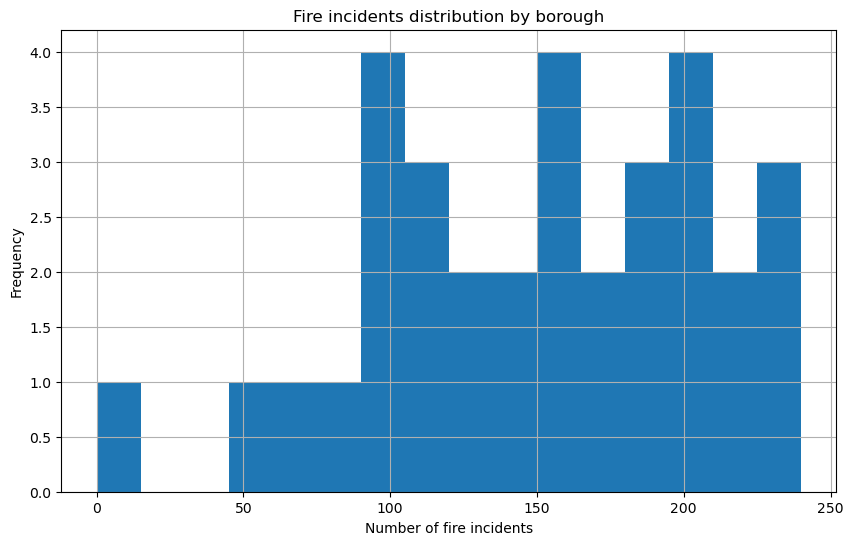

In [16]:
#create histogram
boros['fire_count'].hist(bins=range(0, boros['fire_count'].max() + 15, 15), figsize=(10, 6))

plt.title('Fire incidents distribution by borough')
plt.xlabel('Number of fire incidents')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [17]:
boros['fires_by_1000households']=boros['fire_count']/boros['households']*1000
boros.head(15)

,NAME,GSS_CODE,geometry,fire_count,households,fires_by_1000households
0,Kingston upon Thames,E09000021,"POLYGON ((516401.6 160201.8, 516407.3 160210.5...",57,65626,0.868558
1,Croydon,E09000008,"POLYGON ((535009.2 159504.7, 535005.5 159502, ...",231,152946,1.510337
2,Bromley,E09000006,"POLYGON ((540373.6 157530.4, 540361.2 157551.9...",161,135827,1.185331
3,Hounslow,E09000018,"POLYGON ((521975.8 178100, 521967.7 178096.8, ...",141,102961,1.369451
4,Ealing,E09000009,"POLYGON ((510253.5 182881.6, 510249.9 182886, ...",185,133659,1.384119
5,Havering,E09000016,"POLYGON ((549893.9 181459.8, 549894.6 181465.7...",108,101277,1.066382
6,Hillingdon,E09000017,"POLYGON ((510599.8 191689.5, 510615.2 191591.3...",120,109228,1.098619
7,Harrow,E09000015,"POLYGON ((510599.8 191689.5, 510660 191690.9, ...",86,89642,0.959372
8,Brent,E09000005,"POLYGON ((525201 182512.6, 525181.5 182521.1, ...",185,118612,1.559707
9,Barnet,E09000003,"POLYGON ((524579.9 198355.2, 524594.3 198321.4...",195,148917,1.309454


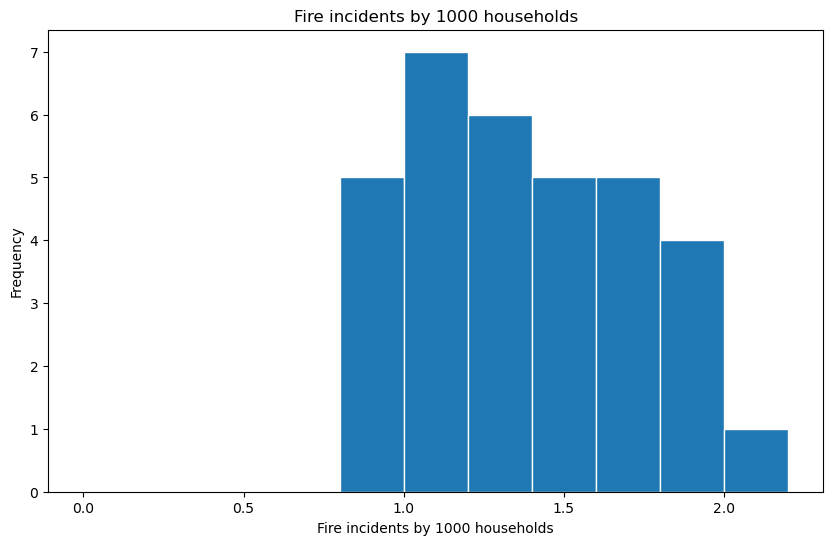

In [18]:
#create histogram
boros['fires_by_1000households'].hist(bins=np.arange(0, boros['fires_by_1000households'].max() + 0.2, 0.2),
                                             figsize=(10, 6),
                                             edgecolor='white')

plt.title('Fire incidents by 1000 households')
plt.xlabel('Fire incidents by 1000 households')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

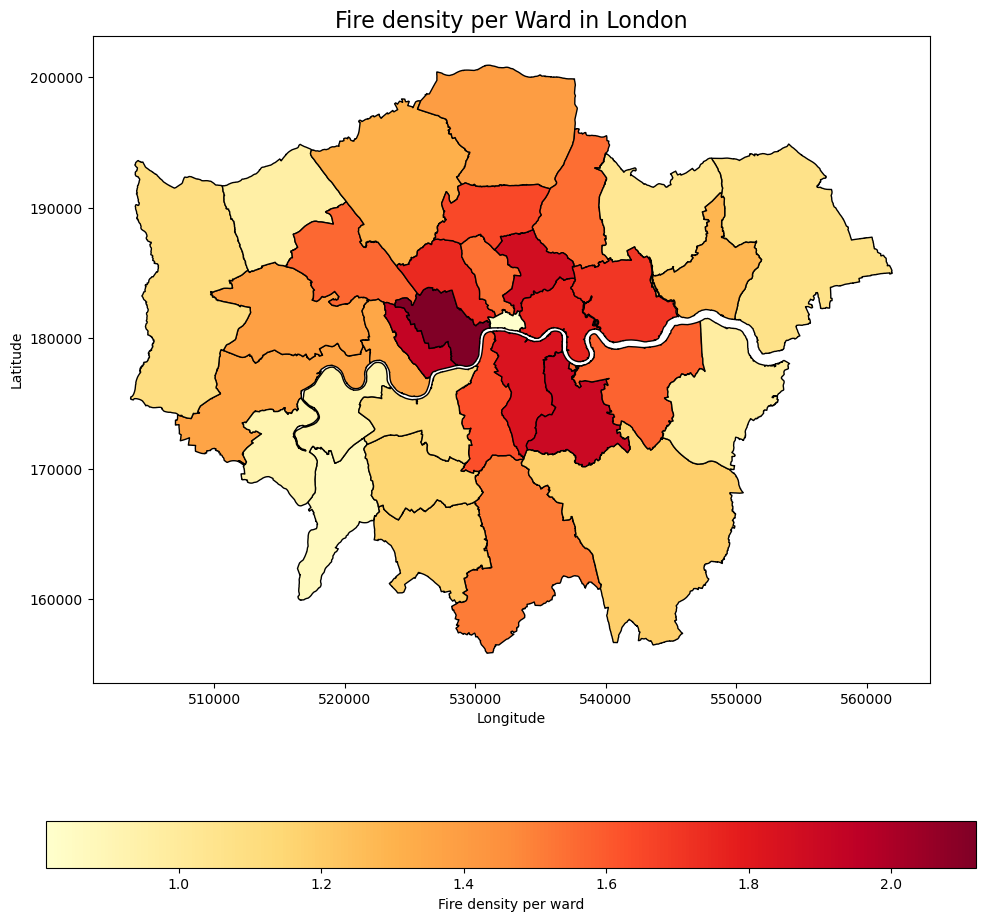

In [19]:
#Plot thematic map on fire incident density
fig, ax = plt.subplots(figsize=(12, 12))

#set thematic map
boros.plot(column='fires_by_1000households', ax=ax, legend=True,
           legend_kwds={'label': "Fire density per ward",
                        'orientation': "horizontal"},
           cmap='YlOrRd',
           edgecolor='black')

plt.title("Fire density per Ward in London", fontsize=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

In [20]:
#Aggregate socio-economic information

columns=['Lower tier local authorities Code', 'Observation']
pop_density=pd.read_csv("TS006-2021-3-filtered-2025-01-19T18_03_57Z.csv", usecols=columns)

boros=boros.merge(pop_density, left_on='GSS_CODE', right_on='Lower tier local authorities Code', how='left')

boros=boros.drop('Lower tier local authorities Code', axis=1)
boros.head()

boros=boros.rename(columns={'Observation':'pop_density'})
boros.head()

,NAME,GSS_CODE,geometry,fire_count,households,fires_by_1000households,pop_density
0,Kingston upon Thames,E09000021,"POLYGON ((516401.6 160201.8, 516407.3 160210.5...",57,65626,0.868558,4512.1
1,Croydon,E09000008,"POLYGON ((535009.2 159504.7, 535005.5 159502, ...",231,152946,1.510337,4516.0
2,Bromley,E09000006,"POLYGON ((540373.6 157530.4, 540361.2 157551.9...",161,135827,1.185331,2197.7
3,Hounslow,E09000018,"POLYGON ((521975.8 178100, 521967.7 178096.8, ...",141,102961,1.369451,5148.0
4,Ealing,E09000009,"POLYGON ((510253.5 182881.6, 510249.9 182886, ...",185,133659,1.384119,6611.6


In [21]:
#load deprivation data
deprivation = pd.read_csv("TS011-2021-2-filtered-2025-01-19T18_08_31Z.csv")

#Create a pivot table with deprivation options
pivot_table = deprivation.pivot_table(
    index='Lower tier local authorities Code',
    columns='Household deprivation (6 categories) Code',
    values='Observation',
    aggfunc='sum',
    fill_value=0
)

pivot_table.reset_index(inplace=True)

# Rename columns
pivot_table.rename(columns={
    -8: 'Not applicable',
    1: 'no_deprivation',
    2: '1d_deprivation',
    3: '2d_deprivation',
    4: '3d_deprivation',
    5: '4d_deprivation'
}, inplace=True)

#Merge with london wards df
boros = boros.merge(
    pivot_table,
    left_on='GSS_CODE',
    right_on='Lower tier local authorities Code',
    how='left'  # Left join
)

#check results
boros.head()

,NAME,GSS_CODE,geometry,fire_count,households,fires_by_1000households,pop_density,Lower tier local authorities Code,Not applicable,no_deprivation,1d_deprivation,2d_deprivation,3d_deprivation,4d_deprivation
0,Kingston upon Thames,E09000021,"POLYGON ((516401.6 160201.8, 516407.3 160210.5...",57,65626,0.868558,4512.1,E09000021,0,36639,20274,7045,1552,116
1,Croydon,E09000008,"POLYGON ((535009.2 159504.7, 535005.5 159502, ...",231,152946,1.510337,4516.0,E09000008,0,73406,51772,21635,5581,552
2,Bromley,E09000006,"POLYGON ((540373.6 157530.4, 540361.2 157551.9...",161,135827,1.185331,2197.7,E09000006,0,74219,42434,15360,3586,228
3,Hounslow,E09000018,"POLYGON ((521975.8 178100, 521967.7 178096.8, ...",141,102961,1.369451,5148.0,E09000018,0,45406,36270,16488,4377,420
4,Ealing,E09000009,"POLYGON ((510253.5 182881.6, 510249.9 182886, ...",185,133659,1.384119,6611.6,E09000009,0,61529,45650,20275,5686,518


In [22]:
boros=boros.drop(['Lower tier local authorities Code', 'Not applicable'],axis=1)

In [23]:
boros['deprived']=boros[['1d_deprivation','2d_deprivation','3d_deprivation','4d_deprivation']].sum(axis=1) 
boros.head()

,NAME,GSS_CODE,geometry,fire_count,households,fires_by_1000households,pop_density,no_deprivation,1d_deprivation,2d_deprivation,3d_deprivation,4d_deprivation,deprived
0,Kingston upon Thames,E09000021,"POLYGON ((516401.6 160201.8, 516407.3 160210.5...",57,65626,0.868558,4512.1,36639,20274,7045,1552,116,28987
1,Croydon,E09000008,"POLYGON ((535009.2 159504.7, 535005.5 159502, ...",231,152946,1.510337,4516.0,73406,51772,21635,5581,552,79540
2,Bromley,E09000006,"POLYGON ((540373.6 157530.4, 540361.2 157551.9...",161,135827,1.185331,2197.7,74219,42434,15360,3586,228,61608
3,Hounslow,E09000018,"POLYGON ((521975.8 178100, 521967.7 178096.8, ...",141,102961,1.369451,5148.0,45406,36270,16488,4377,420,57555
4,Ealing,E09000009,"POLYGON ((510253.5 182881.6, 510249.9 182886, ...",185,133659,1.384119,6611.6,61529,45650,20275,5686,518,72129


In [24]:
income= pd.read_excel('income-of-tax-payers.xlsx', sheet_name='Total Income',  header=[0, 1])
income_code = income[('Unnamed: 0_level_0', 'Code')]

income_median = income[('2021-22', 'Median £')]

income = pd.DataFrame({
    'Code': income_code,
    'Median £': income_median
})
income = income.reset_index(drop=True)

#Perform the left join with the 'boros' DataFrame
boros = boros.merge(income, left_on='GSS_CODE', right_on='Code', how='left')

boros=boros.drop('Code',axis=1)
boros=boros.rename(columns={'Median £': 'median_income'})

boros.head()

,NAME,GSS_CODE,geometry,fire_count,households,fires_by_1000households,pop_density,no_deprivation,1d_deprivation,2d_deprivation,3d_deprivation,4d_deprivation,deprived,median_income
0,Kingston upon Thames,E09000021,"POLYGON ((516401.6 160201.8, 516407.3 160210.5...",57,65626,0.868558,4512.1,36639,20274,7045,1552,116,28987,35900.0
1,Croydon,E09000008,"POLYGON ((535009.2 159504.7, 535005.5 159502, ...",231,152946,1.510337,4516.0,73406,51772,21635,5581,552,79540,30400.0
2,Bromley,E09000006,"POLYGON ((540373.6 157530.4, 540361.2 157551.9...",161,135827,1.185331,2197.7,74219,42434,15360,3586,228,61608,35800.0
3,Hounslow,E09000018,"POLYGON ((521975.8 178100, 521967.7 178096.8, ...",141,102961,1.369451,5148.0,45406,36270,16488,4377,420,57555,29300.0
4,Ealing,E09000009,"POLYGON ((510253.5 182881.6, 510249.9 182886, ...",185,133659,1.384119,6611.6,61529,45650,20275,5686,518,72129,30900.0


In [25]:
unemployment= pd.read_csv('unemployment-by-local-authorities.csv')

unemployment= unemployment[
    (unemployment['time'] == 'Jan2021-Dec2021') &
    (unemployment['ethnicity'] == 'All') &
    (unemployment['ethnicity_type'] == 'All')
]
unemployment= unemployment[['Geography', 'value']]

# Perform left join
boros = boros.merge(
    unemployment,
    how='left',
    left_on='NAME',
    right_on='Geography'
)
boros.rename(columns={'value': 'unemployment'}, inplace=True)

boros.drop(columns=['Geography'], inplace=True)

In [26]:
tenure=pd.read_csv('TS054-2021-3-filtered-2025-01-19T19_32_43Z.csv')

#Create a pivot table with tenure options
pivot_table = tenure.pivot_table(
    index='Lower tier local authorities Code',
    columns='Tenure of household (9 categories) Code',
    values='Observation',
    aggfunc='sum',
    fill_value=0
)

pivot_table.reset_index(inplace=True)

#Group and rename columns
pivot_table['owns'] = pivot_table[0] + pivot_table[1] + pivot_table[2]
pivot_table['rents'] = pivot_table[3] + pivot_table[4] + pivot_table[5]+ pivot_table[6]
pivot_table['other'] = pivot_table[7] + pivot_table[-8]

pivot_table=pivot_table[['Lower tier local authorities Code', 'owns', 'rents']]
pivot_table.head()

Tenure of household (9 categories) Code,Lower tier local authorities Code,owns,rents
0,E09000001,1806,3103
1,E09000002,32593,41163
2,E09000003,80040,68739
3,E09000004,66680,28555
4,E09000005,47839,70602


In [27]:
#Perform the left join with the 'boros' DataFrame
boros = boros.merge(pivot_table, left_on='GSS_CODE', right_on='Lower tier local authorities Code', how='left')
boros=boros.drop('Lower tier local authorities Code', axis=1)
boros.head()

,NAME,GSS_CODE,geometry,fire_count,households,fires_by_1000households,pop_density,no_deprivation,1d_deprivation,2d_deprivation,3d_deprivation,4d_deprivation,deprived,median_income,unemployment,owns,rents
0,Kingston upon Thames,E09000021,"POLYGON ((516401.6 160201.8, 516407.3 160210.5...",57,65626,0.868558,4512.1,36639,20274,7045,1552,116,28987,35900.0,3.1,40397,25155
1,Croydon,E09000008,"POLYGON ((535009.2 159504.7, 535005.5 159502, ...",231,152946,1.510337,4516.0,73406,51772,21635,5581,552,79540,30400.0,5.9,85850,66812
2,Bromley,E09000006,"POLYGON ((540373.6 157530.4, 540361.2 157551.9...",161,135827,1.185331,2197.7,74219,42434,15360,3586,228,61608,35800.0,6.4,94194,41587
3,Hounslow,E09000018,"POLYGON ((521975.8 178100, 521967.7 178096.8, ...",141,102961,1.369451,5148.0,45406,36270,16488,4377,420,57555,29300.0,4.5,49269,53406
4,Ealing,E09000009,"POLYGON ((510253.5 182881.6, 510249.9 182886, ...",185,133659,1.384119,6611.6,61529,45650,20275,5686,518,72129,30900.0,6.8,64472,68872


In [29]:
#Add socioeconomic variables as %
boros['%owns']=boros['owns']/boros['households']*100 
boros['%rents']=boros['rents']/boros['households']*100 
boros['%deprived']=boros['deprived']/boros['households']*100 
boros['%notdeprived']=boros['no_deprivation']/boros['households']*100


In [30]:
boros.head()

,NAME,GSS_CODE,geometry,fire_count,households,fires_by_1000households,pop_density,no_deprivation,1d_deprivation,2d_deprivation,...,4d_deprivation,deprived,median_income,unemployment,owns,rents,%owns,%rents,%deprived,%notdeprived
0,Kingston upon Thames,E09000021,"POLYGON ((516401.6 160201.8, 516407.3 160210.5...",57,65626,0.868558,4512.1,36639,20274,7045,...,116,28987,35900.0,3.1,40397,25155,61.556395,38.330844,44.169994,55.830006
1,Croydon,E09000008,"POLYGON ((535009.2 159504.7, 535005.5 159502, ...",231,152946,1.510337,4516.0,73406,51772,21635,...,552,79540,30400.0,5.9,85850,66812,56.130922,43.683392,52.005283,47.994717
2,Bromley,E09000006,"POLYGON ((540373.6 157530.4, 540361.2 157551.9...",161,135827,1.185331,2197.7,74219,42434,15360,...,228,61608,35800.0,6.4,94194,41587,69.348510,30.617624,45.357698,54.642302
3,Hounslow,E09000018,"POLYGON ((521975.8 178100, 521967.7 178096.8, ...",141,102961,1.369451,5148.0,45406,36270,16488,...,420,57555,29300.0,4.5,49269,53406,47.852099,51.870126,55.899807,44.100193
4,Ealing,E09000009,"POLYGON ((510253.5 182881.6, 510249.9 182886, ...",185,133659,1.384119,6611.6,61529,45650,20275,...,518,72129,30900.0,6.8,64472,68872,48.236183,51.528143,53.964941,46.034311
